In [4]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 7.1MB/s 


# text preprocesing

### 1. code-snipet removal
### 2. html tag removal
### 3. stop word removal
### 4. convering it to lower case
### 5. using snowball stemer

In [5]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import sqlite3 
import seaborn as sns
import re
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from datetime  import datetime

In [10]:
start= datetime.now()
con = sqlite3.connect('/content/drive/MyDrive/machine learning/StackOverflow/train_no_dup.db')
no_dup = pd.read_sql_query('SELECT Title,Body,Tags FROM no_dup ORDER BY RANDOM() LIMIT 500000',con)
con.close()
print('time taken=',datetime.now()-start)

time taken= 0:10:26.508106


In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
stopw = set(stopwords.words('english'))
sno = SnowballStemmer('english')
def clean_code(quest):
  cleaned = re.compile(r'<code>(.?)</code>')
  context = re.sub(cleaned,' ',quest,)
  return context
def clean_html(quest):
  cleaned = re.compile(r'<.*?>')
  context = re.sub(cleaned,' ',quest,)
  return context

In [13]:
start=datetime.now()
clean_ques=[]
for i in range(len(no_dup)):
  filter_sen=[]
  st = str(clean_code(no_dup['Body'][i]))
  st = clean_html(st)
  title = no_dup['Title'][i].encode('utf-8')
  #***giving weight to the title tag bcz it have the more information***#
  question = str(title)+" "+str(title)+" "+str(title)+" "+str(st)
  question=re.sub(r'[^A-Za-z]+',' ',question)
  words=word_tokenize(str(question.lower()))
  question=' '.join(str(sno.stem(j)) for j in words if j not in stopw and (len(j)!=1 or j=='c'))
  clean_ques.append(question)
  if(i%100000==0):
    print("processed data=",i)
print("time taken=",datetime.now()-start)




processed data= 0
processed data= 100000
processed data= 200000
processed data= 300000
processed data= 400000
time taken= 0:15:50.510982


In [14]:
no_dup['Question']=clean_ques

In [15]:
no_dup.head()

,Title,Body,Tags,Question
0,Toggle a hidden div when a particular dropdown...,"<p>Hey everyone, I had a quick question that s...",javascript jquery,toggl hidden div particular dropdown option se...
1,zooming background images with CSS3,<p>I have tried to make gentle zooming backgro...,css3 background background-image,zoom background imag css zoom background imag ...
2,UML mapping: container class with objects of t...,<p>Suppose that there is one container C that ...,class uml uml-modeling class-diagram,uml map contain class object two type uml map ...
3,How to renew the iOS developer License in Indi...,"<p>To Renew the iOS developer license, is ther...",ios,renew io develop licens india without fax form...
4,Flex slow view on ipod,<p>I'm new in flex programming so yesterday I ...,flex,flex slow view ipod flex slow view ipod flex s...


In [16]:
disk_eng = create_engine('sqlite:///Processed_w.db')
no_dup_df = pd.DataFrame(no_dup,columns=['Title','Body','Tags','Question'])
no_dup_df.to_sql('proc_w_que',disk_eng)

In [18]:
con = sqlite3.connect('/content/drive/MyDrive/machine learning/StackOverflow/Processed_w.db')
proc_data = pd.read_sql_query("SELECT Question,Tags FROM proc_w_que",con)
proc_data.dropna(inplace=True,axis=0)

In [19]:
proc_data.head()

,Question,Tags
0,toggl hidden div particular dropdown option se...,javascript jquery
1,zoom background imag css zoom background imag ...,css3 background background-image
2,uml map contain class object two type uml map ...,class uml uml-modeling class-diagram
3,renew io develop licens india without fax form...,ios
4,flex slow view ipod flex slow view ipod flex s...,flex


# Machine learning Models
#### converting the tags fro multilabel problem

In [20]:
vector = CountVectorizer(tokenizer= lambda x : str(x).split(' '),binary=True)
multilabel_y = vector.fit_transform(proc_data['Tags'])

In [21]:
feq = multilabel_y.sum(axis=0).A1
freq_sorted= sorted(range(len(feq)),key=lambda i: feq[i],reverse=True) ## storing the index of the frequency to be in range

In [22]:
def qexp(n):
  x = multilabel_y[:,freq_sorted[:n]].sum(axis=1)
  return np.count_nonzero(x==0)


In [23]:
total_question = len(proc_data)
total_tags = multilabel_y.shape[1]
no_tag=[]
question_explaned = []
for i in range(500,total_tags,100):
  no_tag.append(i)
  question_explaned.append(np.round(((total_question-qexp(i))/total_question)*100,3))

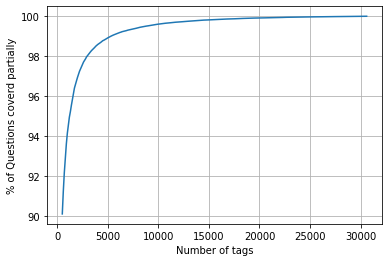

In [24]:
plt.plot(no_tag,question_explaned)
plt.xlabel("Number of tags")
plt.ylabel("% of Questions coverd partially")
plt.grid()
plt.show()

In [25]:
print("at 500 the % of question covered",question_explaned[0])

at 500 the % of question covered 90.105


In [26]:
multilabel_yx=multilabel_y[:,freq_sorted[:500]]

(399999,)

# Spliting the data into Train and test
#### we have limited to 500tag and 5m data point becz of traning time.
#### 80:20 split

In [27]:
total_size=proc_data.shape[0]
train_size = int(.80*total_size)

X_train = proc_data['Question'].head(train_size)
X_test = proc_data['Question'].tail(total_size-train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

# Featuring the data

In [42]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(X_train)
x_test_multilabel = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:59.931865


In [44]:
print("train data size"," x=",x_train_multilabel.shape,"y: ",y_train.shape)
print("test data size"," x=",x_test_multilabel.shape,"y: ",y_test.shape)

train data size  x= (399999, 151040) y:  (399999, 500)
test data size  x= (100000, 151040) y:  (100000, 500)


# Applying onevsrest

In [29]:
from sklearn.model_selection import GridSearchCV

In [45]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23842
Hamming loss  0.00279582
Micro-average quality numbers
Precision: 0.7304, Recall: 0.3580, F1-measure: 0.4805
Macro-average quality numbers
Precision: 0.5393, Recall: 0.2533, F1-measure: 0.3285
              precision    recall  f1-score   support

           0       0.68      0.33      0.45      7805
           1       0.80      0.49      0.61      7104
           2       0.84      0.60      0.70      6869
           3       0.77      0.45      0.57      6236
           4       0.95      0.77      0.85      5536
           5       0.87      0.66      0.75      5244
           6       0.79      0.42      0.55      3419
           7       0.89      0.62      0.73      3188
           8       0.71      0.43      0.54      3132
           9       0.81      0.46      0.58      2922
          10       0.85      0.61      0.71      2890
          11       0.54      0.21      0.30      2781
          12       0.60      0.12      0.20      2734
          13       0.64      0.

In [46]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_weight.pkl') 

['lr_weight.pkl']

In [85]:
pred = classifier.predict(x_train_multilabel[])
print(pred)

  (0, 0)	1
  (0, 26)	1
  (0, 45)	1
  (0, 276)	1


In [86]:
result[feq[freq_sorted[(13)]]]

'ios'